### 🧠 Step 1: Dataset Preparation & Class Weight Computation

- Load images from train, validation, and test directories.
- Resize images to (224, 224) — standard for ResNet50.
- Apply ResNet-specific preprocessing (`preprocess_input`).
- Compute class weights to handle imbalance in NORMAL vs PNEUMONIA.


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_dir = "../data"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Preprocessing using ResNet50
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Compute class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

print(f"\n✅ Class weights: {class_weights}")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

✅ Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


### ⚙️ Step 2: Building ResNet50 Transfer Learning Model

- Use `ResNet50` with ImageNet weights and `include_top=False`.
- Freeze the convolutional base.
- Add global average pooling + dense layers for classification.
- Output layer with sigmoid activation for binary classification.


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the base model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base

# Custom classifier on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 🚀 Step 3: Model Training

- Use `EarlyStopping`, `ReduceLROnPlateau`, and `ModelCheckpoint` callbacks.
- Train the model using class weights to handle imbalance.
- Save the best performing model during training.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
checkpoint = ModelCheckpoint("../models/resnt50/best_resnet50_model.keras", monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# Save final model
model.save("../models/resnt50/final_resnet50_model.keras")


c:\Users\Poojitha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 978s 6s/step - accuracy: 0.7588 - loss: 0.5266 - val_accuracy: 0.7500 - val_loss: 0.4544 - learning_rate: 1.0000e-05
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 874s 5s/step - accuracy: 0.9065 - loss: 0.2549 - val_accuracy: 0.8125 - val_loss: 0.4267 - learning_rate: 1.0000e-05
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 871s 5s/step - accuracy: 0.9240 - loss: 0.1975 - val_accuracy: 0.8750 - val_loss: 0.3736 - learning_rate: 1.0000e-05
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 903s 6s/step - accuracy: 0.9362 - loss: 0.1674 - val_accuracy: 0.9375 - val_loss: 0.3162 - learning_rate: 1.0000e-05
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 864s 5s/step - accuracy: 0.9459 - loss: 0.1391 - val_accuracy: 0.8125 - val_loss: 0.3676 - learning_rate: 1.0000e-05
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 862s 5s/step - accuracy: 0.9481 - loss: 0.1403 - val_accuracy: 0.8750 - val_loss: 0.3487 - learning_rate: 1.0000e-05
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - acc

### 📊 Step 4: Model Evaluation & Visualizations

- Evaluate the model on the test set
- Generate classification report and confusion matrix
- Visualize accuracy and loss for both training and validation sets


c:\Users\Poojitha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.7760 - loss: 0.4977

✅ Test Accuracy: 84.46%
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step

📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.66      0.76       234
   PNEUMONIA       0.82      0.95      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.81      0.82       624
weighted avg       0.85      0.84      0.84       624



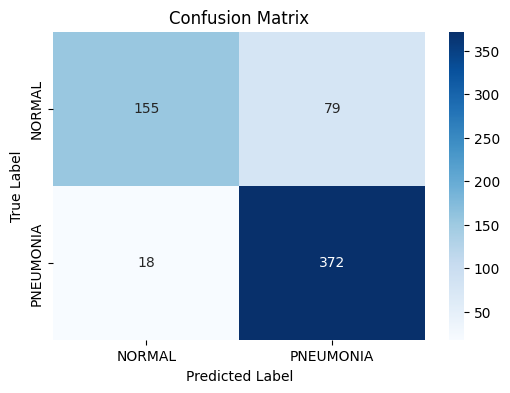

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved model
model = load_model("../models/resnt50/best_resnet50_model.keras")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on test data
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
